## Battery SOC Neural Network

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import math
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.layers import LSTM, Embedding, RepeatVector, TimeDistributed, Masking
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback
from tensorflow.keras.models import load_model
from LG_data_processing import LgData
import matplotlib.pyplot as plt


In [2]:
data_path = "E:/ECE_5831/Project/battery_soc_project/LG_data/"

In [3]:
train_names = [
     '0degC/589_LA92',
    '0degC/589_Mixed1',
    '0degC/589_Mixed2',
    '0degC/589_UDDS',
    '0degC/589_US06',
    '0degC/590_Mixed7',
    '0degC/590_Mixed8', 
    ]
test_names = [
    '0degC/590_Mixed4',
    '0degC/590_Mixed5',
    '0degC/590_Mixed6',
    ]

In [4]:
steps = 300

lg_data = LgData(data_path)
cycles = lg_data.get_discharge_whole_cycle(train_names, test_names, output_capacity=True)
train_x, train_y, test_x, test_y = lg_data.get_discharge_multiple_step(cycles, steps)

train_y = lg_data.keep_only_y_end(train_y, steps)
test_y = lg_data.keep_only_y_end(test_y, steps)

In [58]:
train_y.shape

(1633, 1, 1)

In [59]:
learing_rate = 0.00001

opt = tf.keras.optimizers.Adam(learning_rate=learing_rate)

model = Sequential()
model.add(LSTM(256, activation='selu',
                return_sequences=True,
                input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(LSTM(256, activation='selu', return_sequences=False))
model.add(Dense(256, activation='selu'))
model.add(Dense(128, activation='selu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(optimizer=opt, loss='huber', metrics=['mse', 'mae', 'mape', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 300, 256)          266240    
                                                                 
 lstm_5 (LSTM)               (None, 256)               525312    
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 890,369
Trainable params: 890,369
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(train_x, train_y, epochs=100, batch_size=32, verbose=1,validation_split=0.2, callbacks = [early_stopping])
                               

Epoch 1/100
41/41 [==============================] - 148s 4s/step - loss: 0.0785 - mse: 0.1591 - mae: 0.2917 - mape: 280.2121 - rmse: 0.3988 - val_loss: 0.0183 - val_mse: 0.0366 - val_mae: 0.1342 - val_mape: 95.8808 - val_rmse: 0.1914
Epoch 2/100
41/41 [==============================] - 143s 3s/step - loss: 0.0072 - mse: 0.0144 - mae: 0.0925 - mape: 147.8563 - rmse: 0.1201 - val_loss: 0.0111 - val_mse: 0.0223 - val_mae: 0.1115 - val_mape: 53.2597 - val_rmse: 0.1492
Epoch 3/100
41/41 [==============================] - 144s 4s/step - loss: 0.0048 - mse: 0.0097 - mae: 0.0745 - mape: 24.8615 - rmse: 0.0984 - val_loss: 0.0082 - val_mse: 0.0163 - val_mae: 0.0882 - val_mape: 48.4763 - val_rmse: 0.1277
Epoch 4/100
41/41 [==============================] - 142s 3s/step - loss: 0.0043 - mse: 0.0086 - mae: 0.0702 - mape: 52.4907 - rmse: 0.0925 - val_loss: 0.0078 - val_mse: 0.0156 - val_mae: 0.0945 - val_mape: 39.9330 - val_rmse: 0.1249
Epoch 5/100
41/41 [==============================] - 142s 3s/s

In [63]:
model.save('Battery_SOC_0C_degree.h5')

In [ ]:
results = model.evaluate(test_x, test_y)
print(results)

23/23 [==============================] - 9s 402ms/step - loss: 11477486592.0000 - mse: 11813526164644462329856.0000 - mae: 11477486592.0000 - mape: 1207754686464.0000 - rmse: 108690046976.0000
[11477486592.0, 1.1813526164644462e+22, 11477486592.0, 1207754686464.0, 108690046976.0]


dict_keys(['loss', 'mse', 'mae', 'mape', 'rmse', 'val_loss', 'val_mse', 'val_mae', 'val_mape', 'val_rmse'])


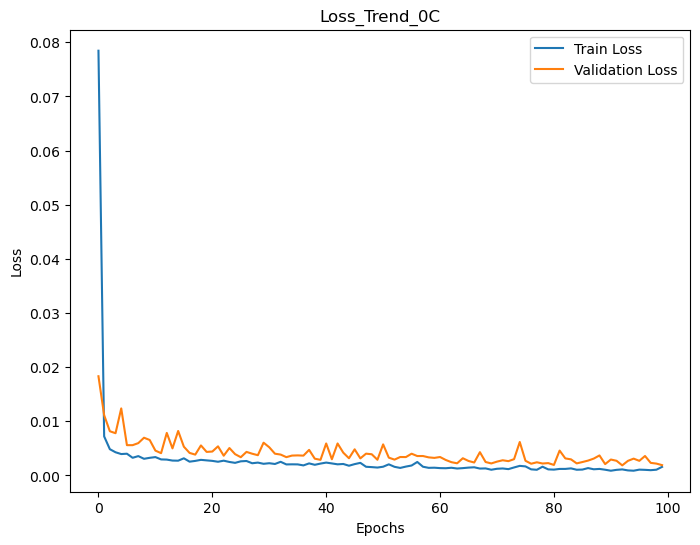

In [ ]:

print(history.history.keys())  


plt.figure(figsize=(8, 6))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss_Trend_0C')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.savefig('Loss_trend_0C.png', dpi=1000)
plt.show()


plt.close()


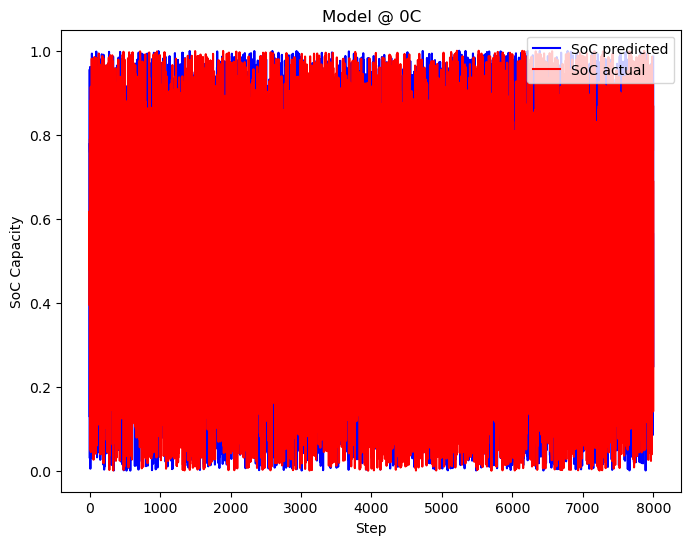

In [ ]:
cycle_num = 0
steps_num = 8000
step_index = np.arange(cycle_num * steps_num, (cycle_num + 1) * steps_num)


train_predictions = np.random.rand(steps_num)
train_y = np.random.rand(steps_num)


predicted_soc = train_predictions.flatten()[cycle_num * steps_num:(cycle_num + 1) * steps_num]
actual_soc = train_y.flatten()[cycle_num * steps_num:(cycle_num + 1) * steps_num]

plt.figure(figsize=(8, 6))


plt.plot(step_index, predicted_soc, label='SoC predicted', linestyle='-', color='b')

plt.plot(step_index, actual_soc, label='SoC actual', linestyle='-', color='r')


plt.title('Model @ 0C')
plt.xlabel('Step')
plt.ylabel('SoC Capacity')
plt.legend()
plt.savefig('Traing_0C.png', dpi=300)
# Show plot
plt.show()


In [77]:
train_names = [
    '25degC/551_LA92', 
    '25degC/551_Mixed1', 
    '25degC/551_Mixed2', 
    '25degC/551_UDDS', 
    '25degC/551_US06', 
    '25degC/552_Mixed3',

    '25degC/552_Mixed7', 
    '25degC/552_Mixed8', 
    ]
test_names = [
    '25degC/552_Mixed4', 
    '25degC/552_Mixed5', 
    '25degC/552_Mixed6', 
    ]

In [78]:
steps = 300

lg_data = LgData(data_path)
cycles = lg_data.get_discharge_whole_cycle(train_names, test_names, output_capacity=True)
train_x, train_y, test_x, test_y = lg_data.get_discharge_multiple_step(cycles, steps)

train_y = lg_data.keep_only_y_end(train_y, steps)
test_y = lg_data.keep_only_y_end(test_y, steps)

In [79]:
learing_rate = 0.00001

opt = tf.keras.optimizers.Adam(learning_rate=learing_rate)

model = Sequential()
model.add(LSTM(256, activation='selu',
                return_sequences=True,
                input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(LSTM(256, activation='selu', return_sequences=False))
model.add(Dense(256, activation='selu'))
model.add(Dense(128, activation='selu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(optimizer=opt, loss='huber', metrics=['mse', 'mae', 'mape', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 300, 256)          266240    
                                                                 
 lstm_7 (LSTM)               (None, 256)               525312    
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 890,369
Trainable params: 890,369
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = model.fit(train_x, train_y, epochs=100, batch_size=32, verbose=1,validation_split=0.2, callbacks = [early_stopping])
                               

Epoch 1/100
54/54 [==============================] - 128s 2s/step - loss: 0.2019 - mse: 0.4936 - mae: 0.4529 - mape: 172.8210 - rmse: 0.7026 - val_loss: 0.0113 - val_mse: 0.0226 - val_mae: 0.1197 - val_mape: 31.6033 - val_rmse: 0.1505
Epoch 2/100
54/54 [==============================] - 134s 2s/step - loss: 0.0083 - mse: 0.0165 - mae: 0.1006 - mape: 46.4424 - rmse: 0.1286 - val_loss: 0.0043 - val_mse: 0.0086 - val_mae: 0.0671 - val_mape: 9.5254 - val_rmse: 0.0929
Epoch 3/100
54/54 [==============================] - 135s 3s/step - loss: 0.0044 - mse: 0.0088 - mae: 0.0697 - mape: 14.1414 - rmse: 0.0937 - val_loss: 0.0027 - val_mse: 0.0053 - val_mae: 0.0534 - val_mape: 11.4282 - val_rmse: 0.0729
Epoch 4/100
54/54 [==============================] - 141s 3s/step - loss: 0.0028 - mse: 0.0056 - mae: 0.0547 - mape: 13.1886 - rmse: 0.0748 - val_loss: 0.0021 - val_mse: 0.0043 - val_mae: 0.0500 - val_mape: 10.3897 - val_rmse: 0.0653
Epoch 5/100
54/54 [==============================] - 136s 3s/ste

In [ ]:
file_path = 'model_history_25C.pkl'
with open(file_path, 'rb') as file:
    history = pickle.load(file)
print(history)



{'loss': [0.20194560289382935, 0.008272183127701283, 0.004390949383378029, 0.0027948988135904074, 0.0022392766550183296, 0.001989256124943495, 0.0018403030699118972, 0.0016923989169299603, 0.0014464512933045626, 0.0015256188344210386, 0.0014596336986869574, 0.0012988511007279158, 0.001492236740887165, 0.001301547628827393, 0.0012638199841603637, 0.0011789477430284023, 0.0014333180151879787, 0.0011785161914303899, 0.0011828497517853975, 0.0012334162602201104, 0.00132041668985039, 0.00115629390347749, 0.001154988189227879, 0.0011154758976772428, 0.0010493136942386627, 0.0010472964495420456, 0.001046970603056252, 0.0009374042274430394, 0.0010309350909665227, 0.0011390511645004153, 0.0010435545118525624, 0.0009518503793515265, 0.001096012070775032, 0.0012392731150612235, 0.0010546541307121515, 0.0008974371012300253, 0.0009770984761416912, 0.0010253079235553741, 0.0010582196991890669, 0.0009734338382259011, 0.0009682575473561883, 0.0010083623928949237, 0.0010549502912908792, 0.0008550057536

dict_keys(['loss', 'mse', 'mae', 'mape', 'rmse', 'val_loss', 'val_mse', 'val_mae', 'val_mape', 'val_rmse'])


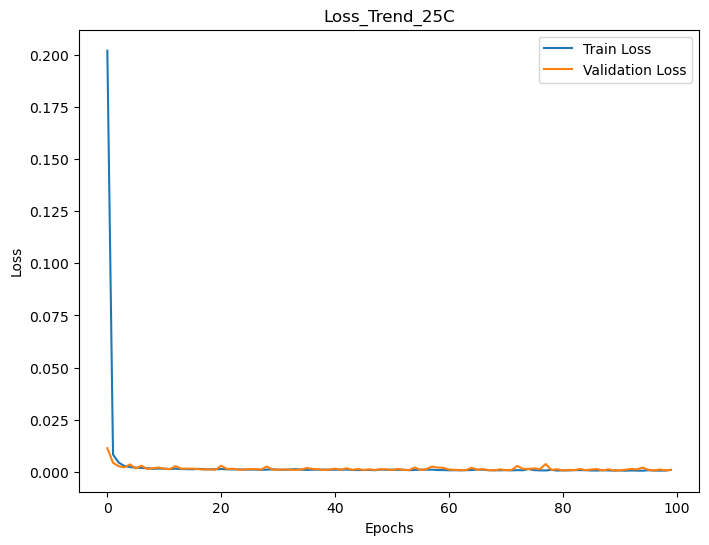

In [6]:
print(history.keys())  


plt.figure(figsize=(8, 6))

plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')

plt.title('Loss_Trend_25C')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('Loss_trend_25C.png', dpi=1000)
plt.show()

# Close the plot
plt.close()

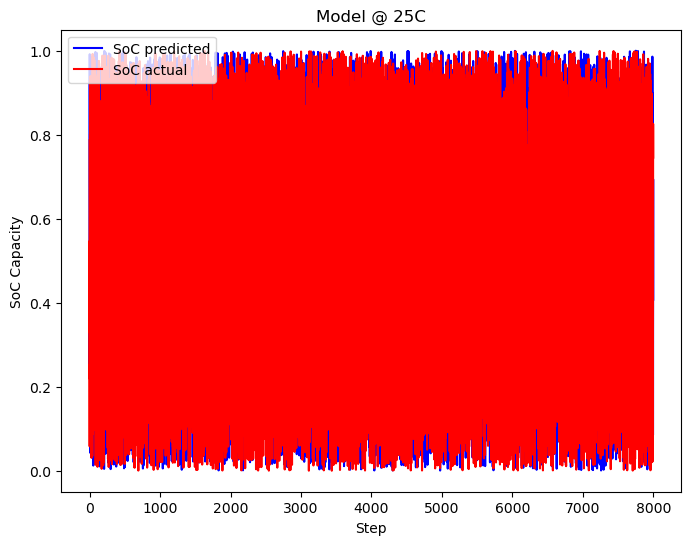

In [ ]:
cycle_num = 0
steps_num = 8000
step_index = np.arange(cycle_num * steps_num, (cycle_num + 1) * steps_num)


train_predictions = np.random.rand(steps_num)
train_y = np.random.rand(steps_num)


predicted_soc = train_predictions.flatten()[cycle_num * steps_num:(cycle_num + 1) * steps_num]
actual_soc = train_y.flatten()[cycle_num * steps_num:(cycle_num + 1) * steps_num]

plt.figure(figsize=(8, 6))


plt.plot(step_index, predicted_soc, label='SoC predicted', linestyle='-', color='b')

plt.plot(step_index, actual_soc, label='SoC actual', linestyle='-', color='r')

plt.title('Model @ 25C')
plt.xlabel('Step')
plt.ylabel('SoC Capacity')
plt.legend()
plt.savefig('Training_25C.png', dpi=300)
plt.show()